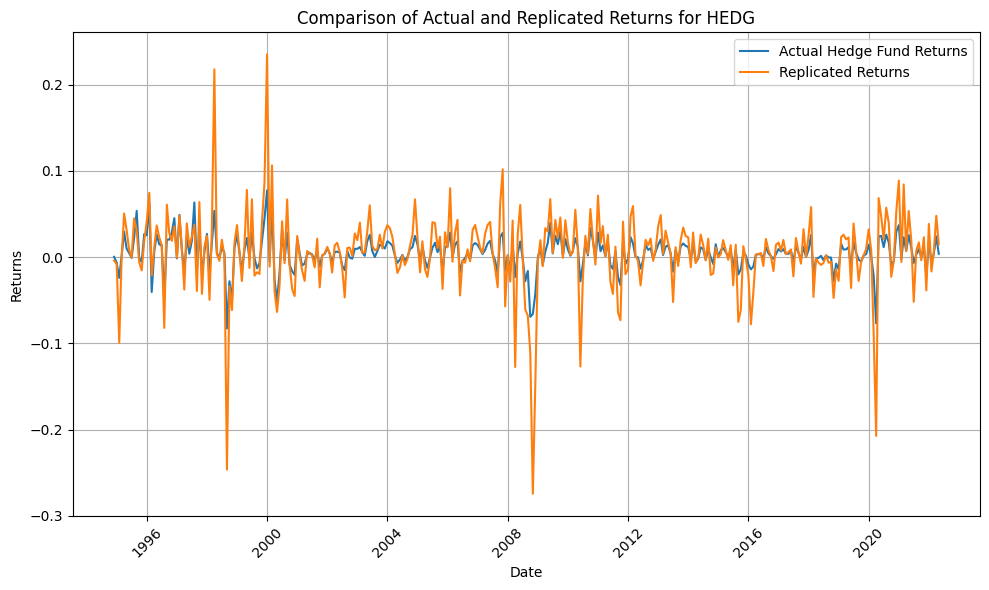

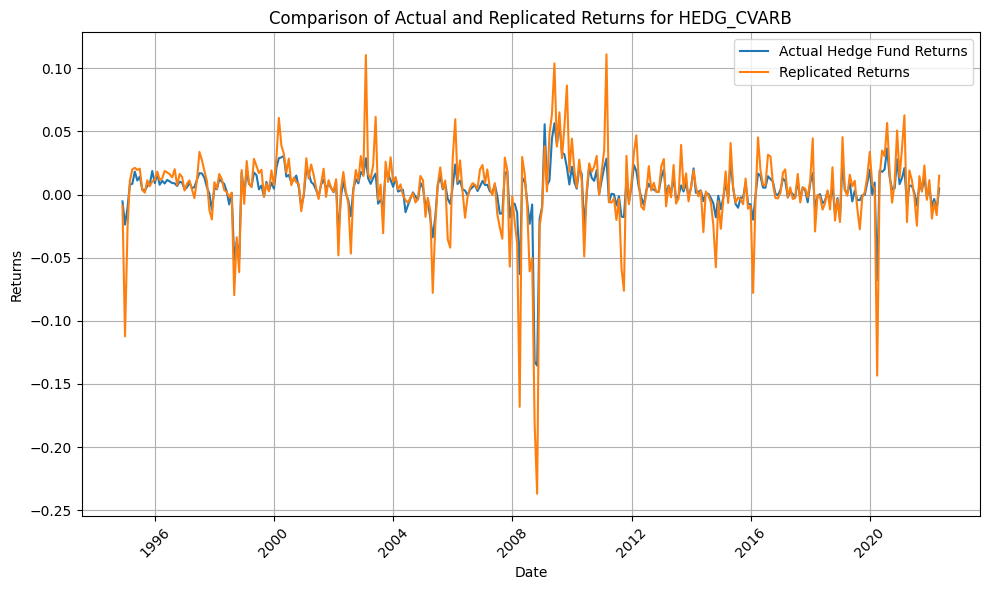

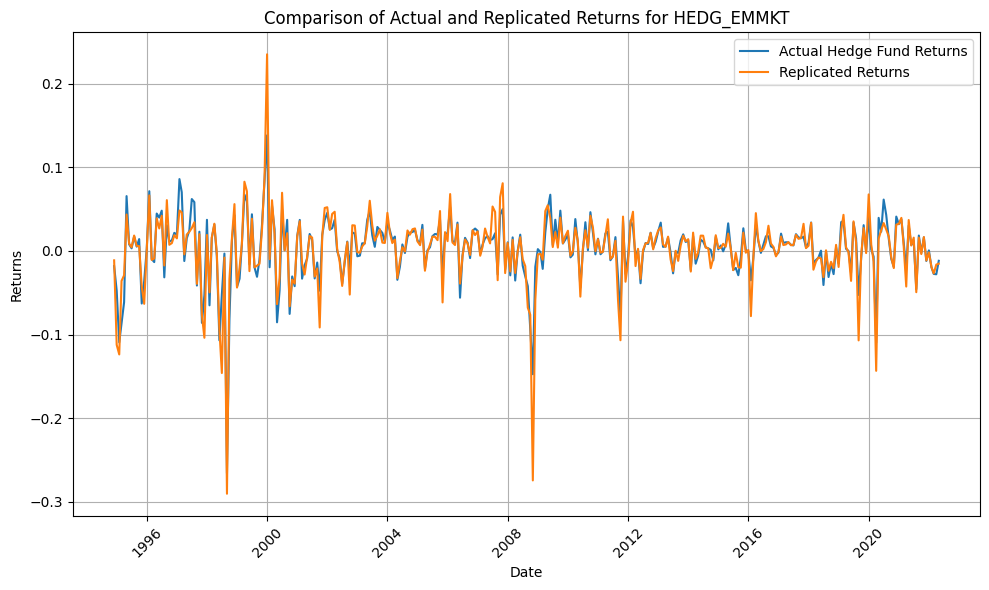

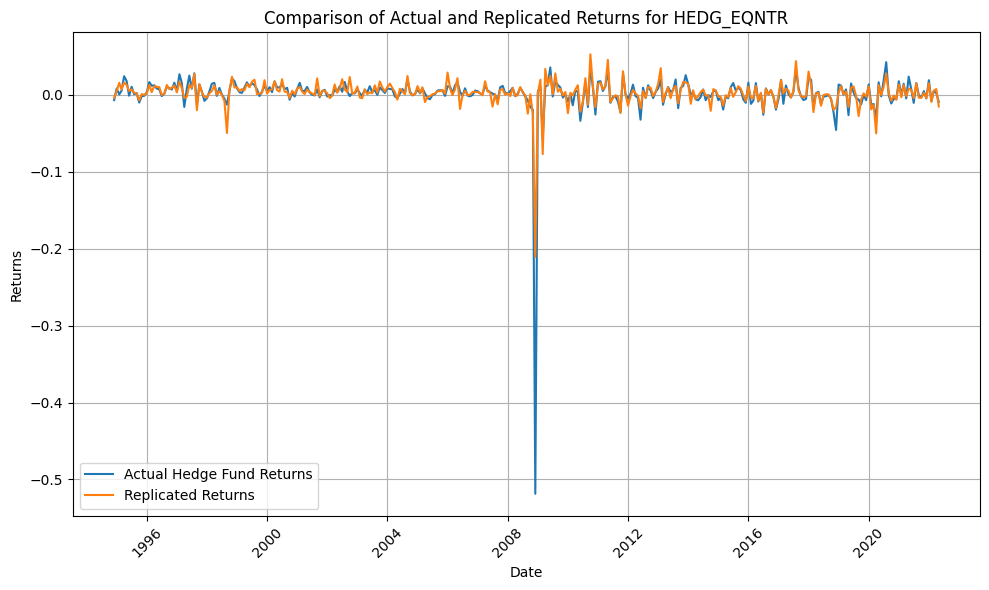

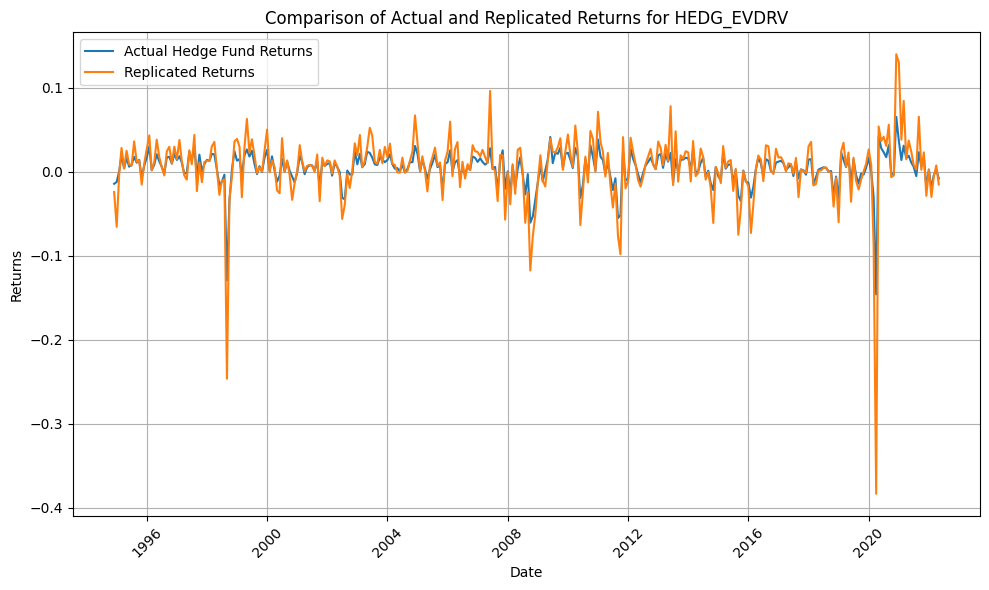

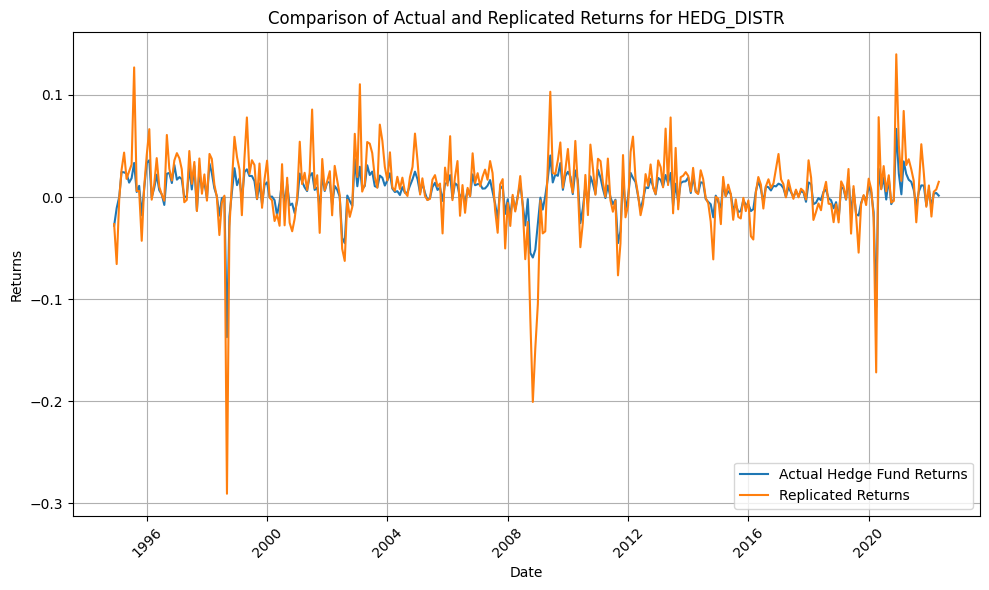

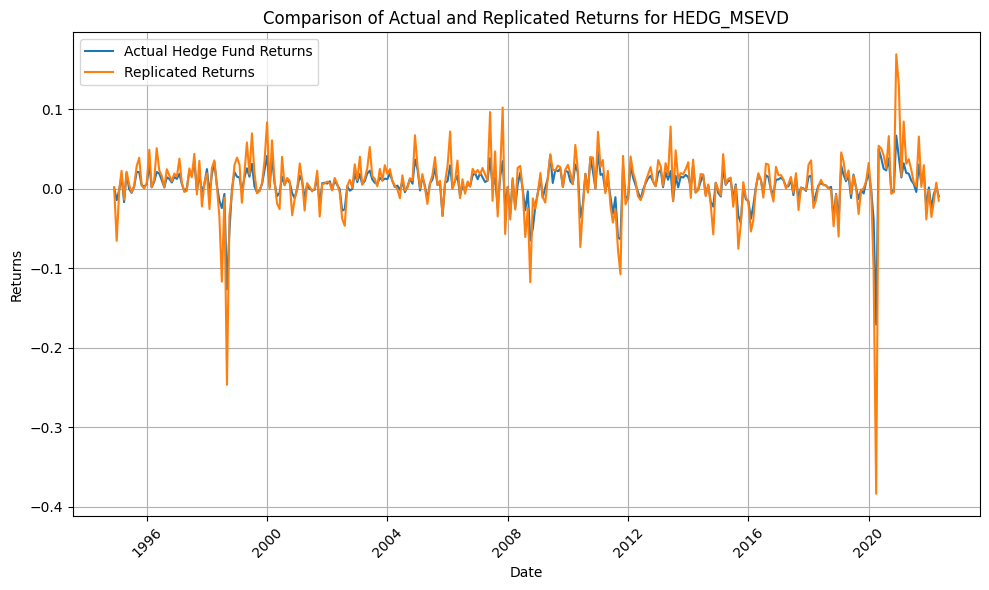

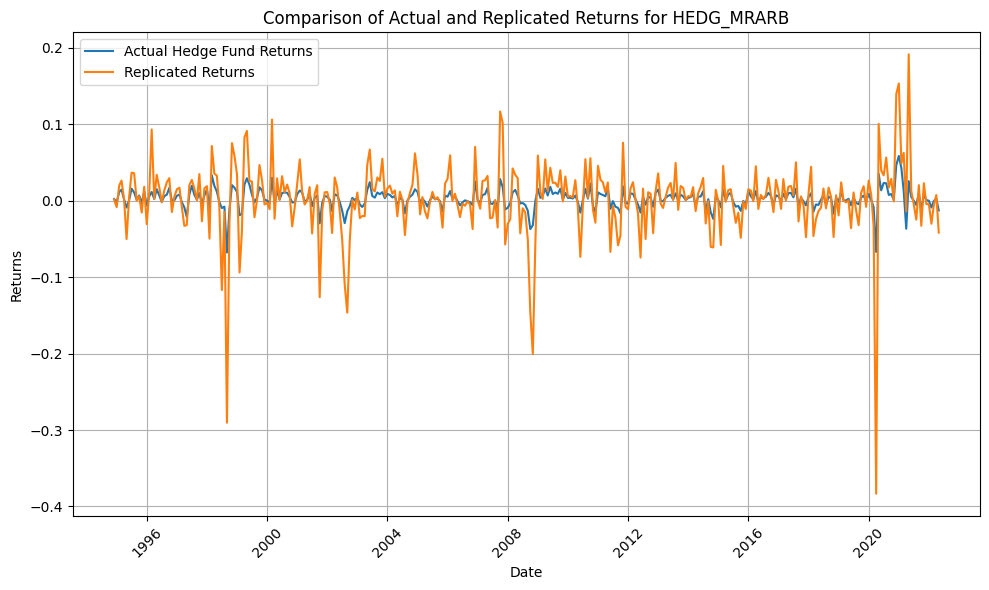

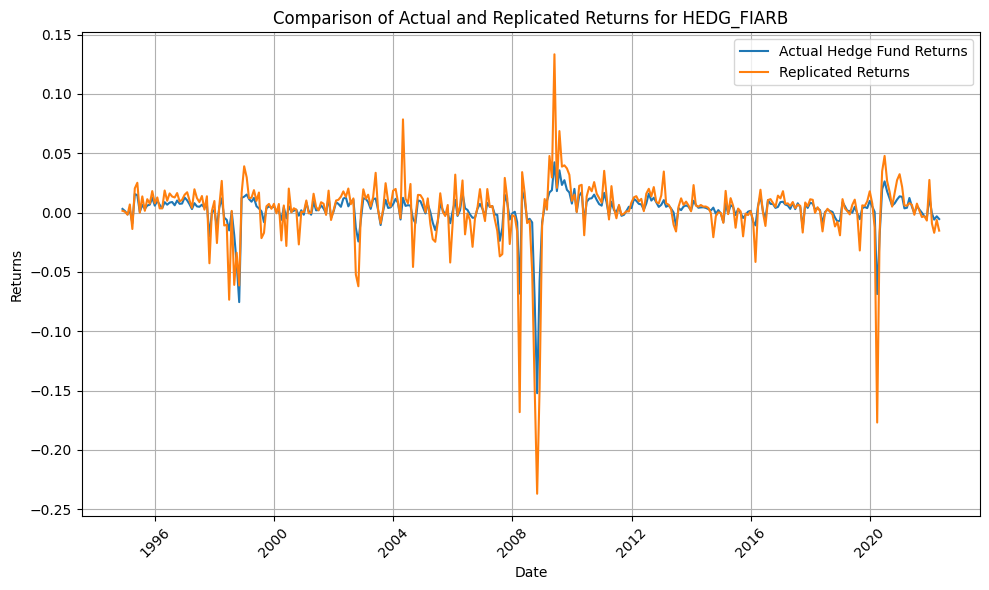

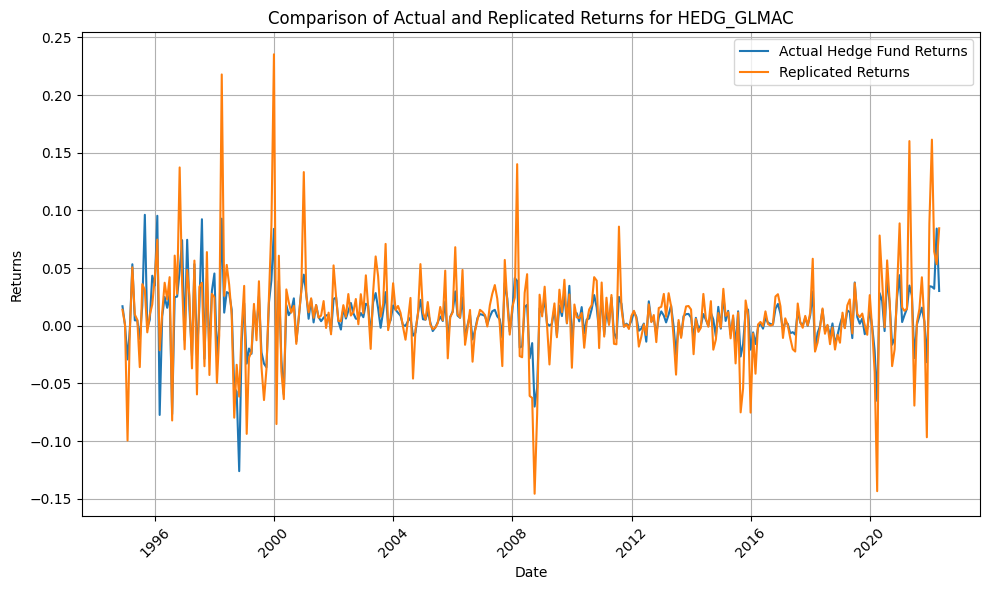

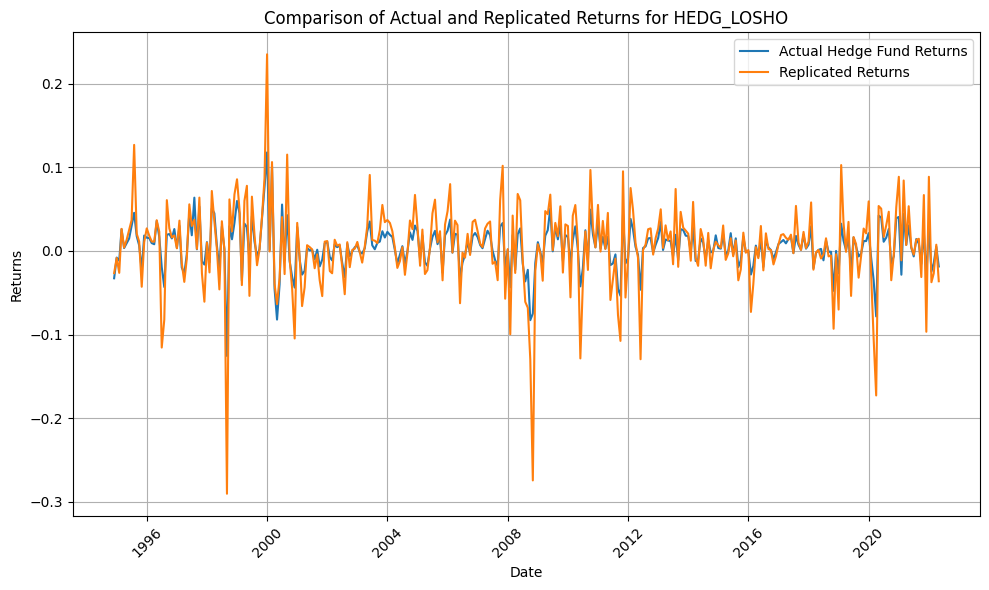

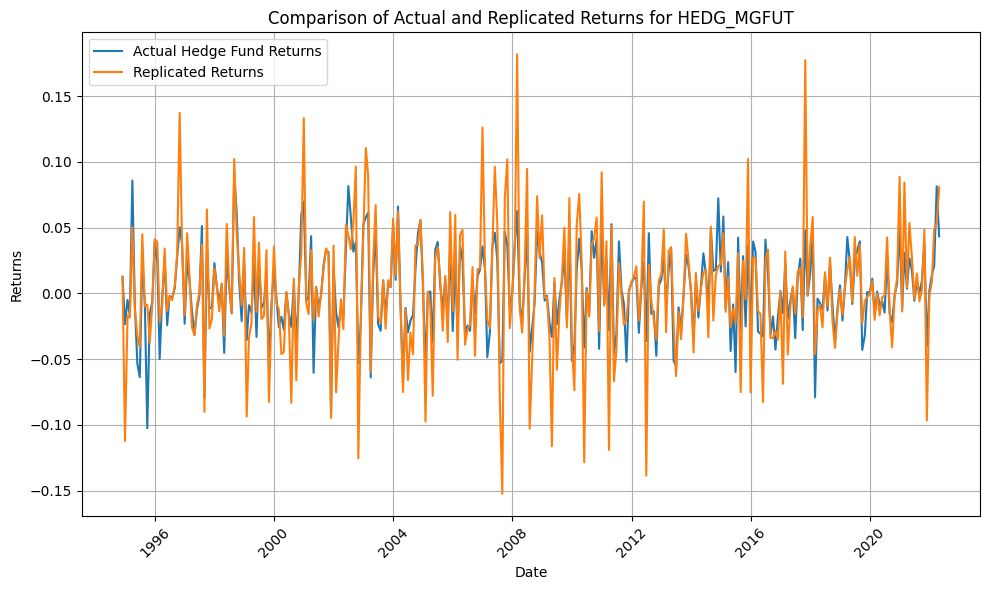

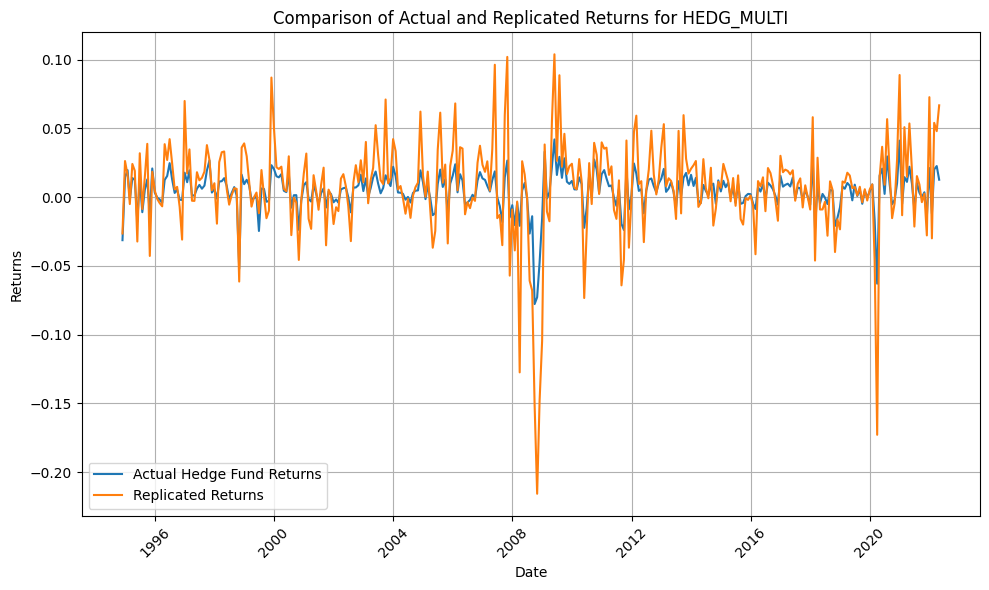

[*********************100%%**********************]  1 of 1 completed


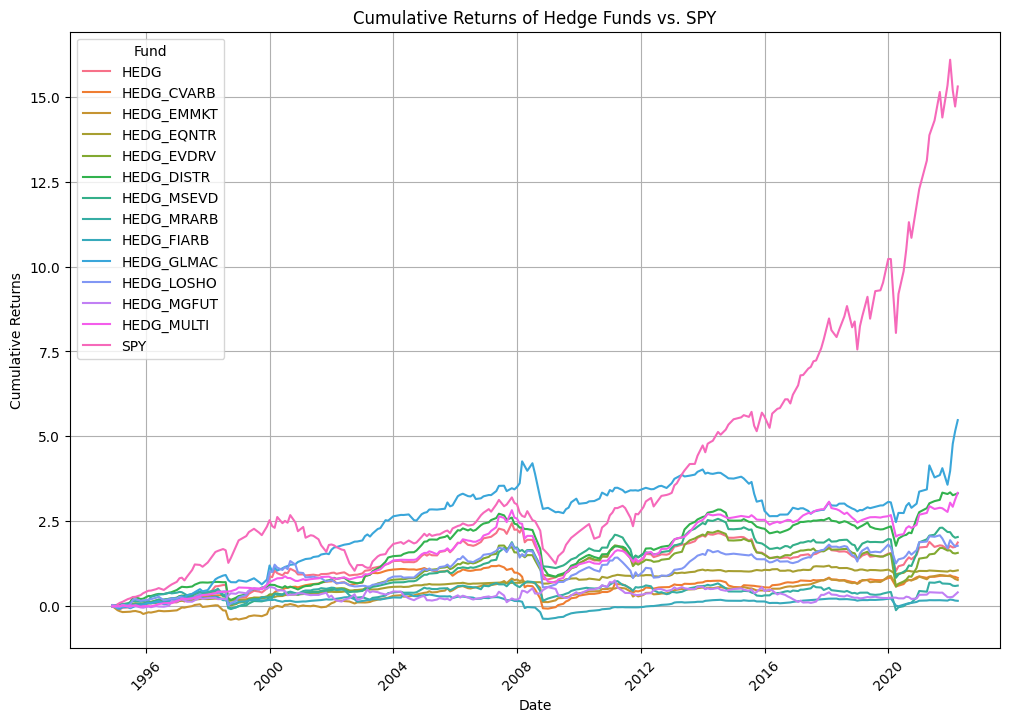

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import matplotlib.dates as mdates
import plotly.express as px
import pandas as pd
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)


# Function to read data
def read_data(etf_path, hedge_fund_path):
    etf_data = pd.read_csv(etf_path, index_col=0, parse_dates=True)
    hedge_fund_data = pd.read_csv(hedge_fund_path, index_col=0, parse_dates=True)
    return etf_data, hedge_fund_data

# Function to calculate volatility and Sortino Ratio
def calculate_volatility_sortino(data, threshold_return):
    for col in data.columns:
        # Calculate Volatility
        data[f'{col}_Volatility'] = data[col].rolling(window=8).std()

        # Calculate Sortino Ratio
        returns_below_threshold = data[col][data[col] < threshold_return]
        downside_std = returns_below_threshold.std()
        data[f'{col}_Sortino_Ratio'] = (data[col] - threshold_return) / downside_std if downside_std != 0 else np.nan
    return data

# Function to create new data structure
def create_new_data(data, num_items):
    new_data = pd.DataFrame()
    for x in range(0, num_items):
        if x == 0:
            indices = [0, num_items, num_items + 1]
        else:
            indices = [0 + x, num_items + (x * 2), num_items + 1 + (x * 2)]
        selected_columns = data.iloc[:, indices]
        new_data = pd.concat([new_data, selected_columns], axis=1)
    new_data.index = data.index
    new_data.dropna(inplace=True)
    return new_data

# Function to perform KNN and calculate mean returns
def perform_knn(hfd_data_new, etf_data_new):
    num_hedge_funds = len(hfd_data_new.columns) // 3
    blank_df = pd.DataFrame(index=hfd_data_new.index, columns=range(num_hedge_funds))

    for i in range(len(hfd_data_new)):
        # Get data for the current date
        etf_row = etf_data_new.iloc[i]
        hfd_row = hfd_data_new.iloc[i]

        # Reshape data
        hfd_features = hfd_row.values.reshape(-1, 3)
        etf_features_flat = etf_row.values.reshape(-1, 3)

        # Create DataFrames
        hfd_tuples_df = pd.DataFrame(hfd_features, columns=['Return', 'Volatility', 'Sortino'])
        etf_tuples_df = pd.DataFrame(etf_features_flat, columns=['Return', 'Volatility', 'Sortino'])

        # Check for NaN values
        if hfd_tuples_df.isnull().values.any() or etf_tuples_df.isnull().values.any():
            continue

        # KNN Model
        knn_model = NearestNeighbors(n_neighbors=3)
        knn_model.fit(etf_features_flat)
        _, indices = knn_model.kneighbors(hfd_features)

        # Calculate mean returns
        for col, idx_list in enumerate(indices):
            nearest_neighbor_returns = etf_tuples_df.iloc[idx_list]['Return']
            mean_returns = nearest_neighbor_returns.mean()
            blank_df.iloc[i, col] = mean_returns

    # Set columns
    hedge_fund_names = hfd_data_new.columns[::3]
    blank_df.columns = hedge_fund_names
    return blank_df


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_hedge_fund_vs_replicated(hedge_funds, replicated_returns):
    hedge_funds_columns = hedge_funds.columns
    replicated_columns = replicated_returns.columns

    # Ensure the indices are datetime objects for proper plotting
    hedge_funds = hedge_funds.copy()
    hedge_funds.index = pd.to_datetime(hedge_funds.index)
    replicated_returns = replicated_returns.copy()
    replicated_returns.index = pd.to_datetime(replicated_returns.index)

    for i in range(len(hedge_funds_columns)):
        plt.figure(figsize=(10, 6))

        # Plot Actual Hedge Fund Returns
        sns.lineplot(x=hedge_funds.index, y=hedge_funds[hedge_funds_columns[i]], label='Actual Hedge Fund Returns')

        # Plot Replicated Returns
        sns.lineplot(x=replicated_returns.index, y=replicated_returns[replicated_columns[i]], label='Replicated Returns')

        # Customize the plot
        plt.title(f"Comparison of Actual and Replicated Returns for {hedge_funds_columns[i]}")
        plt.xlabel("Date")
        plt.ylabel("Returns")
        plt.legend(loc='best')
        plt.grid(True)
        plt.xticks(rotation=45)

        # Save the plot as a PNG file
        plt.tight_layout()
        plt.savefig(f'Comparison_{hedge_funds_columns[i]}.png')

        # Show the plot
        plt.show()




# Function to fetch SPY data
def fetch_spy_data(start_date, end_date):
    spy_data = yf.download('SPY', start=start_date, end=end_date)
    spy_data['Returns'] = spy_data['Adj Close'].pct_change().dropna()
    spy_data['Cumulative Returns'] = (1 + spy_data['Returns']).cumprod() - 1
    return spy_data

# Function to calculate cumulative returns
def calculate_cumulative_returns(data):
    cumulative_returns = (1 + data).cumprod() - 1
    return cumulative_returns




def plot_cumulative_returns(cumulative_returns, spy_data):
    # Ensure that the indices are datetime objects
    cumulative_returns = cumulative_returns.copy()
    cumulative_returns.index = pd.to_datetime(cumulative_returns.index)
    spy_data = spy_data.copy()
    spy_data.index = pd.to_datetime(spy_data.index)

    # Reset index to columns for plotting
    cumulative_returns = cumulative_returns.reset_index().rename(columns={'index': 'Date'})
    spy_data = spy_data.reset_index()

    # Melt the cumulative_returns dataframe to long format
    cumulative_returns_melted = cumulative_returns.melt(id_vars='Date', var_name='Hedge Fund', value_name='Cumulative Returns')

    # Prepare SPY data
    spy_cumulative = spy_data[['Date', 'Cumulative Returns']]
    spy_cumulative['Hedge Fund'] = 'SPY'

    # Combine data
    combined_data = pd.concat([cumulative_returns_melted, spy_cumulative], ignore_index=True)

    # Create the line plot using seaborn
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=combined_data, x='Date', y='Cumulative Returns', hue='Hedge Fund')

    # Customize the plot
    plt.title('Cumulative Returns of Hedge Funds vs. SPY')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.xticks(rotation=45)
    plt.legend(title='Fund')
    plt.grid(True)

    # Save the plot as a PNG file
    plt.savefig('cumulative_returns_vs_spy.png', format='png')

    # Show the plot
    plt.show()




def main():
    etf_path = '/Users/nicholassaliba/downloads/factor_etf_data.csv'
    hedge_fund_path = '/Users/nicholassaliba/downloads/hfd.csv'

    # Read data
    etf_data, hedge_fund_data = read_data(etf_path, hedge_fund_path)

    # Ensure indices are datetime
    etf_data.index = pd.to_datetime(etf_data.index)
    hedge_fund_data.index = pd.to_datetime(hedge_fund_data.index)

    # Calculate volatility and Sortino Ratio
    threshold_return = 0.03 / 12
    etf_data = calculate_volatility_sortino(etf_data, threshold_return)
    hedge_fund_data = calculate_volatility_sortino(hedge_fund_data, threshold_return)

    # Create new data structures
    etf_data_new = create_new_data(etf_data, num_items=22)
    hfd_data_new = create_new_data(hedge_fund_data, num_items=13)

    # Get hedge fund returns
    hedge_funds = hfd_data_new[hfd_data_new.columns[::3]]

    # Perform KNN
    replicated_returns = perform_knn(hfd_data_new, etf_data_new)

    # Align indices and columns
    replicated_returns.index = hedge_funds.index
    replicated_returns.columns = hedge_funds.columns

    # Plot hedge fund returns vs. replicated returns
    plot_hedge_fund_vs_replicated(hedge_funds, replicated_returns)

    # Fetch SPY data
    spy_data = fetch_spy_data(start_date=hedge_funds.index.min(), end_date=hedge_funds.index.max())

    # Ensure SPY index is datetime
    spy_data.index = pd.to_datetime(spy_data.index)

    # Align indices
    common_index = hedge_funds.index.intersection(spy_data.index)
    cumulative_returns = calculate_cumulative_returns(replicated_returns.loc[common_index])
    spy_data = spy_data.loc[common_index]

    # Plot cumulative returns
    plot_cumulative_returns(cumulative_returns, spy_data)

if __name__ == "__main__":
    main()
